In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings 
warnings.filterwarnings('ignore')

from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [3]:
df_train = pd.read_csv('train.csv')
original = pd.read_csv('ObesityDataSet.csv')
df_test = pd.read_csv('test.csv')

In [4]:
print(f'Train: {df_train.shape[0]} rows, {df_train.shape[1]} columns')
print(f'Test: {df_test.shape[0]} rows, {df_test.shape[1]} columns')

Train: 20758 rows, 18 columns
Test: 13840 rows, 17 columns


In [5]:
df_train.describe().to_csv('output.csv', index=False)

In [6]:
display('Train:',df_train.head())
display('Test:',df_test.head())

'Train:'

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


'Test:'

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,20758,Male,26.899886,1.848294,120.644178,yes,yes,2.938616,3.000000,Sometimes,no,2.825629,no,0.855400,0.000000,Sometimes,Public_Transportation
1,20759,Female,21.000000,1.600000,66.000000,yes,yes,2.000000,1.000000,Sometimes,no,3.000000,no,1.000000,0.000000,Sometimes,Public_Transportation
2,20760,Female,26.000000,1.643355,111.600553,yes,yes,3.000000,3.000000,Sometimes,no,2.621877,no,0.000000,0.250502,Sometimes,Public_Transportation
3,20761,Male,20.979254,1.553127,103.669116,yes,yes,2.000000,2.977909,Sometimes,no,2.786417,no,0.094851,0.000000,Sometimes,Public_Transportation
4,20762,Female,26.000000,1.627396,104.835346,yes,yes,3.000000,3.000000,Sometimes,no,2.653531,no,0.000000,0.741069,Sometimes,Public_Transportation


In [7]:
def plot_categorical_distribution(feature_name):
    feature_counts = df_train[feature_name].value_counts()
    
    plt.figure(figsize=(8, 8))
    feature_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140)
    plt.title(f'Percentage Distribution of {feature_name}')
    plt.ylabel('')  # Remove y-label
    plt.show()

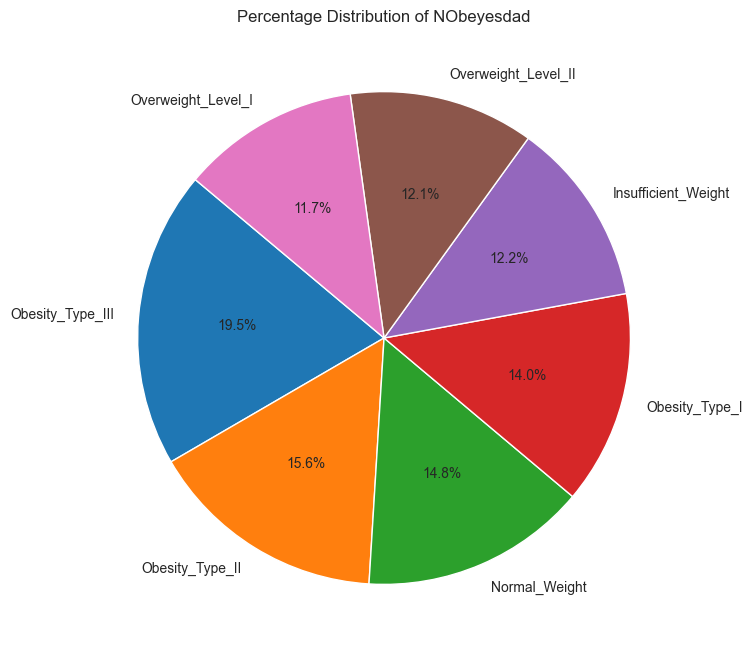

In [8]:
plot_categorical_distribution("NObeyesdad")

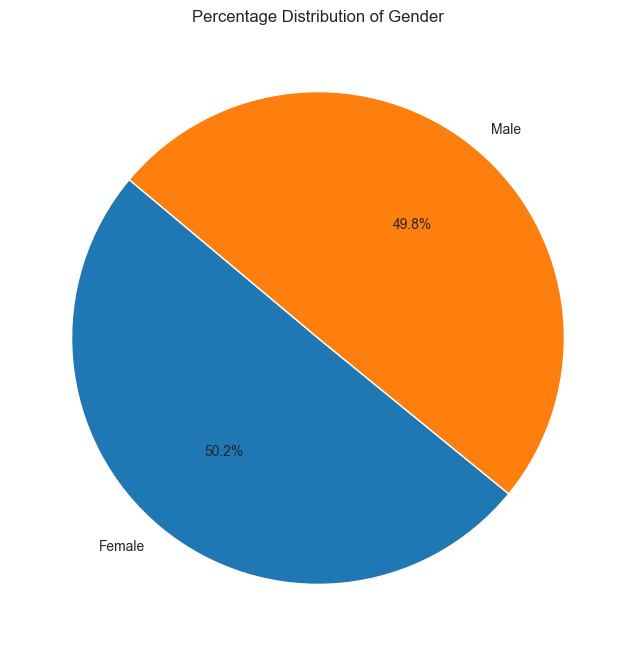

In [9]:
plot_categorical_distribution("Gender")

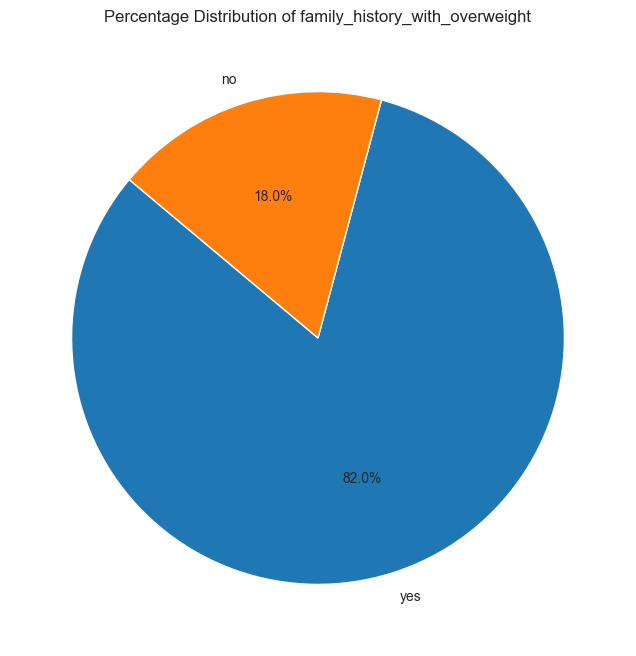

In [10]:
plot_categorical_distribution("family_history_with_overweight")

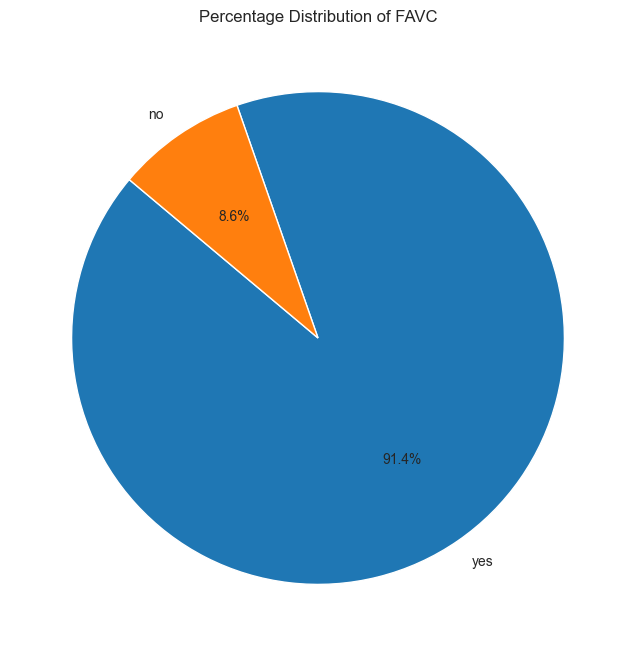

In [11]:
plot_categorical_distribution("FAVC")

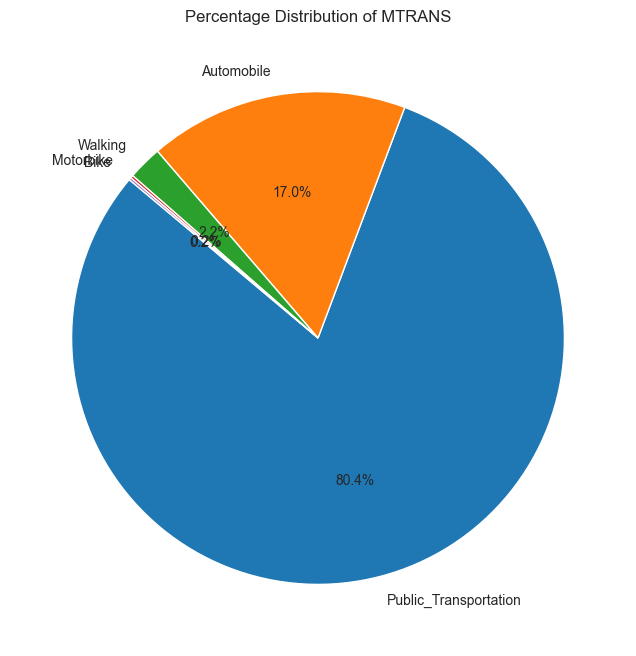

In [12]:
plot_categorical_distribution("MTRANS")

In [13]:
numeric_columns = df_train.select_dtypes(include=['float64', 'int64']).drop(columns=['id'], axis=1)
def dist(train_dataset, original_dataset, columns_list, rows, cols):
    fig, axs = plt.subplots(rows, cols, figsize=(24, 10))
    axs = axs.flatten()
    
    for i, col in enumerate(columns_list):
        sns.kdeplot(train_dataset[col], ax=axs[i], fill=True, alpha=0.5, linewidth=0.5, color='#05b0a3', label='Train')
        sns.kdeplot(original_dataset[col], ax=axs[i], fill=True, alpha=0.5, linewidth=0.5, color='#d68c78', label='Original')
        axs[i].set_title(f'{col}, Train skewness: {train_dataset[col].skew():.2f}\n Original skewness: {original_dataset[col].skew():.2f}')
        axs[i].legend()
        
    plt.tight_layout()

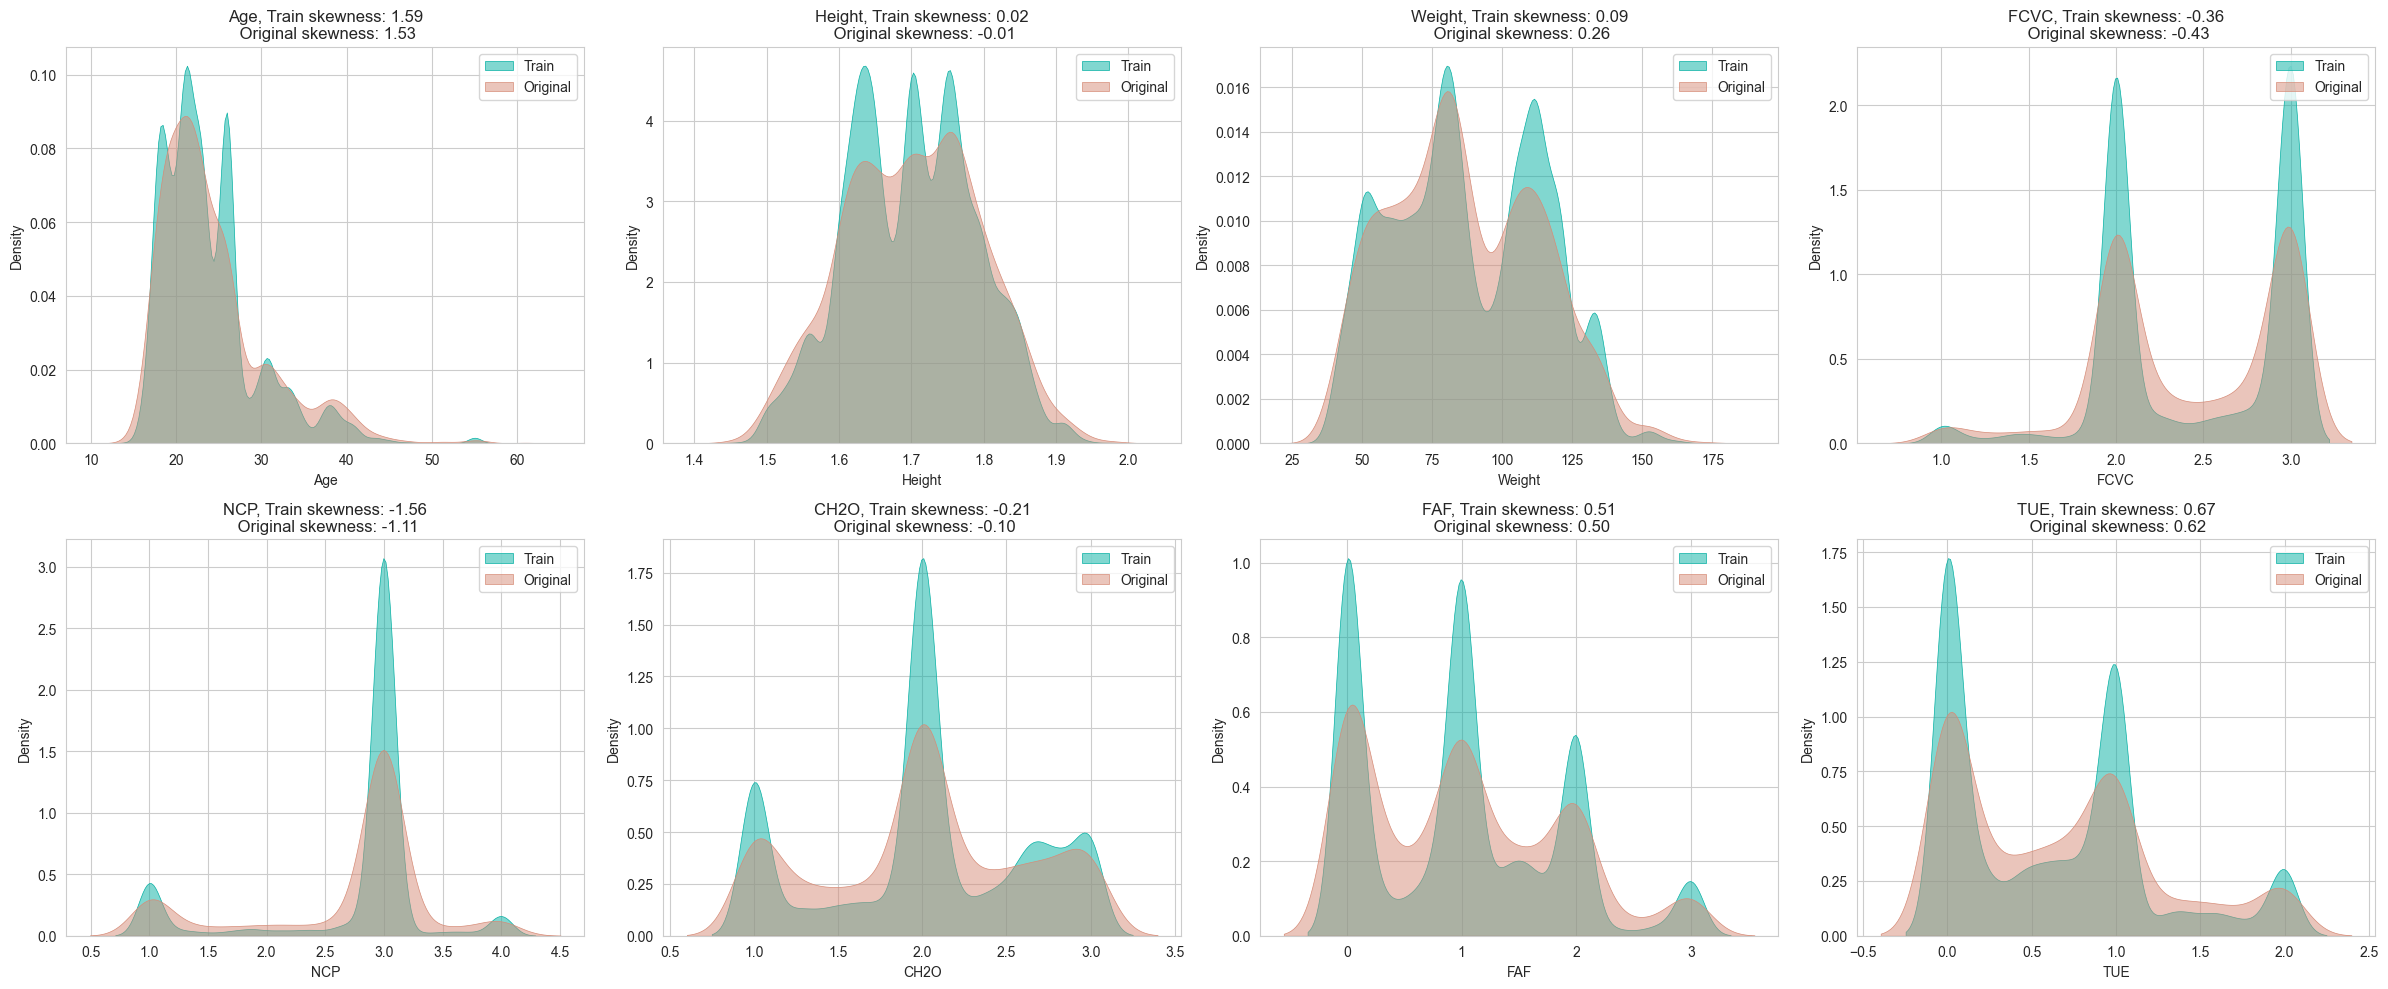

In [14]:
dist(train_dataset=df_train, original_dataset=original, columns_list=numeric_columns.columns, rows=2, cols=4)

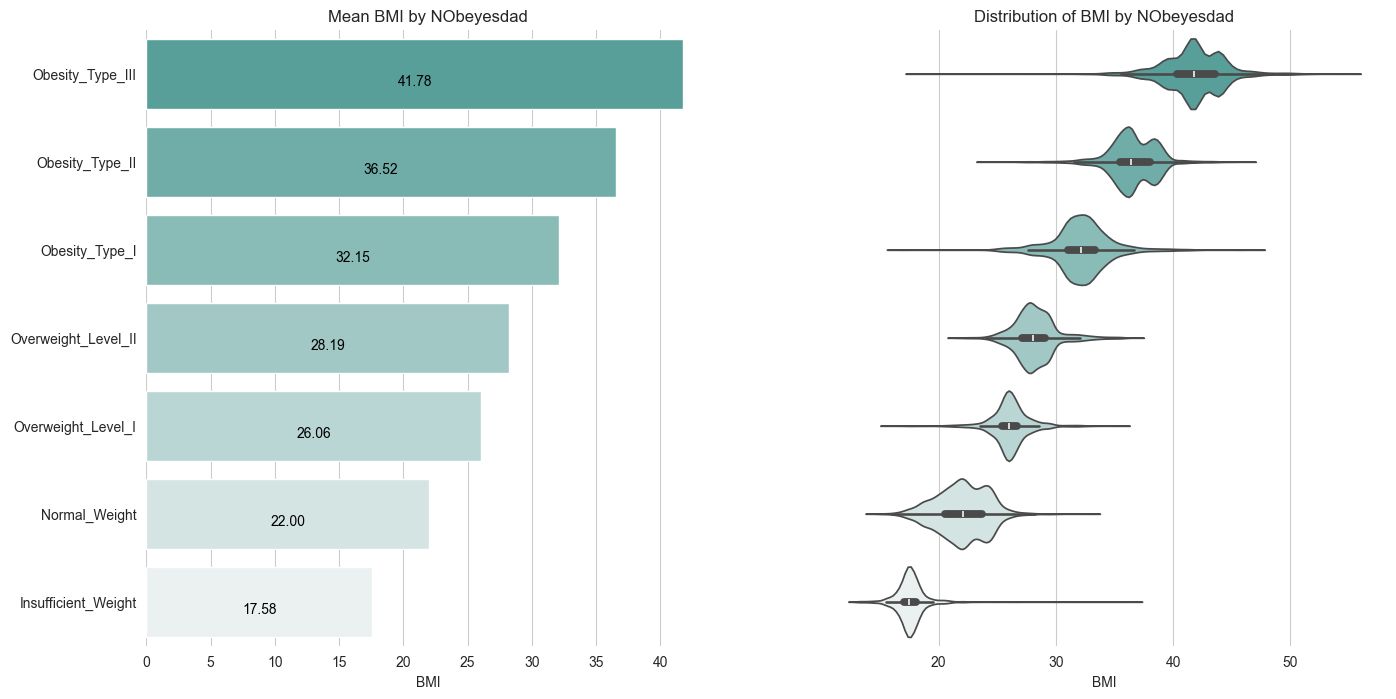

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
df_train['BMI']=  df_train['Weight'] / df_train['Height']**2
ax1 = axes[0]
df_sort = df_train.groupby('NObeyesdad')['BMI'].mean().sort_values(ascending=False).index
sns.barplot(x='BMI', y='NObeyesdad', data=df_train, palette='light:#4caba4_r', order=df_sort,
            estimator=np.mean, ci=None, errwidth=0, ax=ax1)
for p in ax1.patches:
    ax1.annotate(f'{p.get_width():.2f}', (p.get_x() + p.get_width() / 2., p.get_y() + p.get_height()),
                ha='center', va='center', xytext=(0, 20), textcoords='offset points', fontsize=10, color='black')
ax1.set_title('Mean BMI by NObeyesdad')
ax1.set_xlabel('BMI')
ax1.set_ylabel('')
sns.despine(left=True, bottom=True, ax=ax1)

# Violin Plot
ax2 = axes[1]
sns.violinplot(x='BMI', y='NObeyesdad', data=df_train, palette='light:#4caba4_r', order=df_sort, ax=ax2)
ax2.set_title('Distribution of BMI by NObeyesdad')
ax2.set_ylabel("")
plt.yticks([])
sns.despine(left=True, bottom=True, ax=ax2)

In [16]:
df_train.groupby('NObeyesdad')['BMI'].describe().reset_index().style.background_gradient()

,NObeyesdad,count,mean,std,min,25%,50%,75%,max
0,Insufficient_Weight,2523.000000,17.583619,1.388408,12.868541,17.025801,17.506390,18.025957,36.778115
1,Normal_Weight,3082.000000,22.000999,2.194097,14.631670,20.568937,22.038567,23.661439,32.882414
2,Obesity_Type_I,2910.000000,32.154649,2.513458,16.597443,31.020408,32.121386,33.298647,46.805188
3,Obesity_Type_II,3248.000000,36.521958,2.112538,24.048460,35.436970,36.378753,38.023475,46.222483
4,Obesity_Type_III,4046.000000,41.781745,2.670789,18.178670,40.371119,41.750620,43.615233,54.997991
5,Overweight_Level_I,2427.000000,26.059270,1.768697,15.761880,25.390625,25.963757,26.672763,35.555556
6,Overweight_Level_II,2522.000000,28.192491,1.835666,21.513859,27.080170,28.020083,29.086346,36.741456


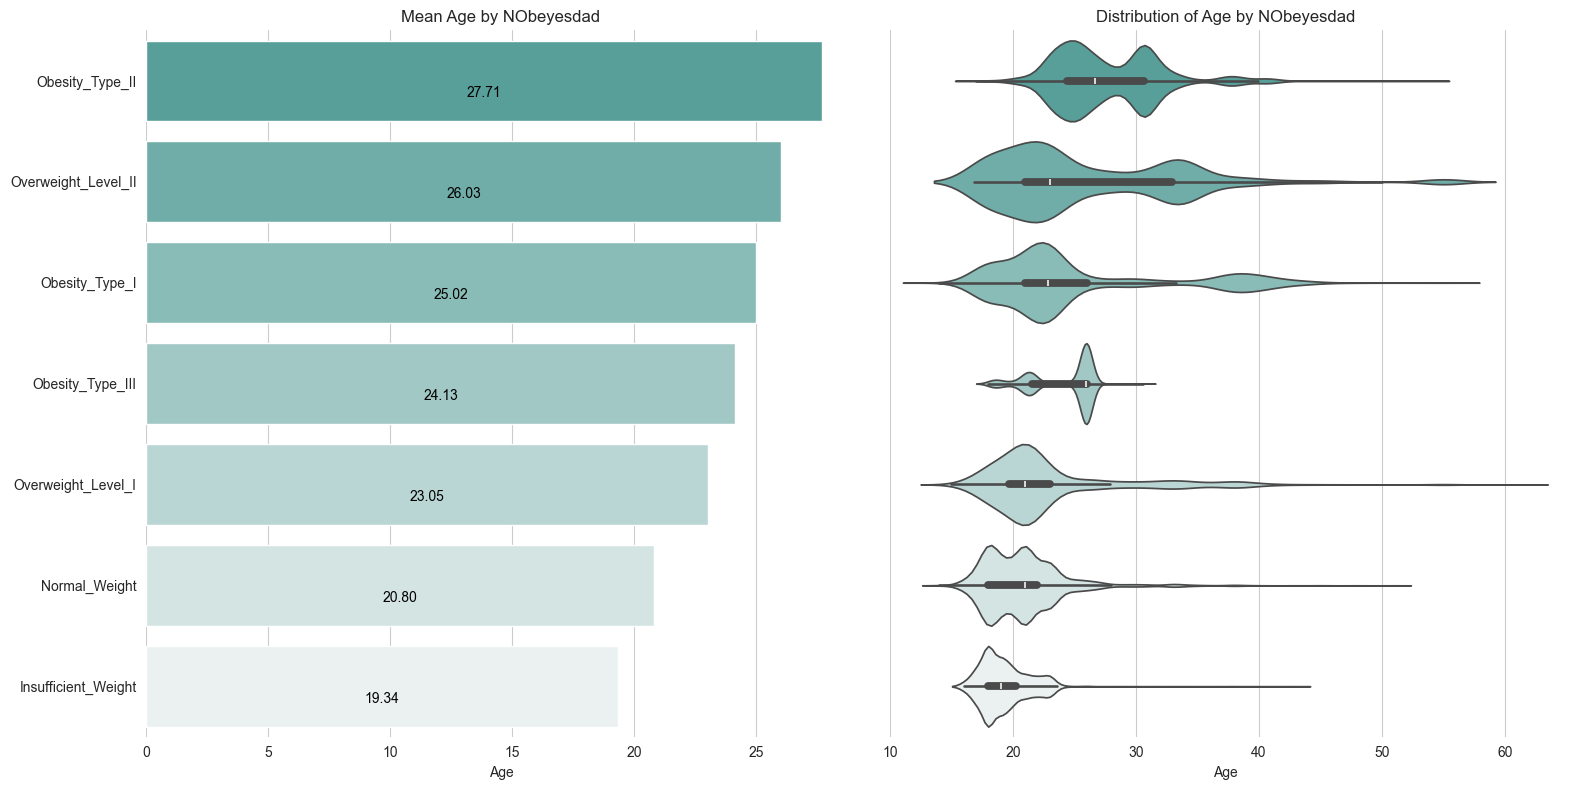

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
ax1 = axes[0]
df_sort = df_train.groupby('NObeyesdad')['Age'].mean().sort_values(ascending=False).index
sns.barplot(x='Age', y='NObeyesdad', data=df_train, palette='light:#4caba4_r', order=df_sort,
            estimator=np.mean, ci=None, errwidth=0, ax=ax1)
for p in ax1.patches:
    ax1.annotate(f'{p.get_width():.2f}', (p.get_x() + p.get_width() / 2., p.get_y() + p.get_height()),
                ha='center', va='center', xytext=(0, 20), textcoords='offset points', fontsize=10, color='black')
ax1.set_title('Mean Age by NObeyesdad')
ax1.set_xlabel('Age')
ax1.set_ylabel('')
sns.despine(left=True, bottom=True, ax=ax1)

# Violin Plot
ax2 = axes[1]
sns.violinplot(x='Age', y='NObeyesdad', data=df_train, palette='light:#4caba4_r', order=df_sort, ax=ax2)
ax2.set_title('Distribution of Age by NObeyesdad')
ax2.set_ylabel("")
plt.yticks([])
sns.despine(left=True, bottom=True, ax=ax2)
plt.tight_layout()
plt.show()

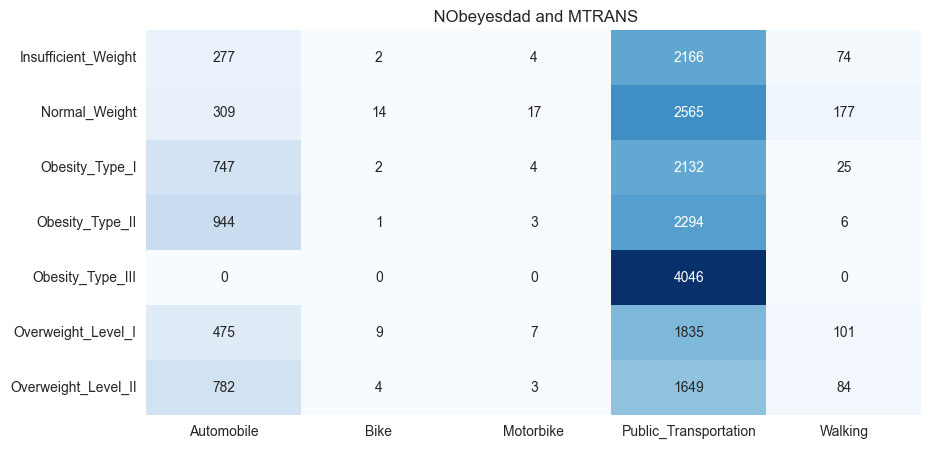

In [18]:
cross_tab = pd.crosstab(df_train['NObeyesdad'], df_train['MTRANS'])
plt.figure(figsize=(10, 5))
sns.heatmap(cross_tab, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title(' NObeyesdad and MTRANS')
plt.xlabel('')
plt.ylabel('')
plt.show()

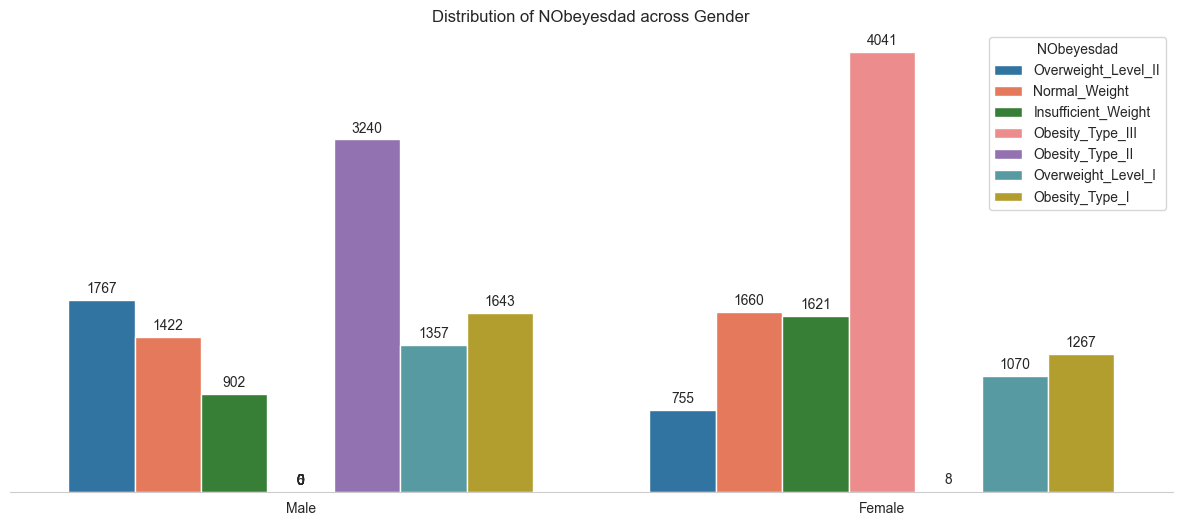

In [19]:
colors = ['#1f77b4', '#fc6c44', '#2b8a2b', '#fc7c7c', '#9467bd', '#4ba4ad', '#c7ad18', '#7f7f7f', '#69d108']

plt.figure(figsize=(15, 6))
ax = sns.countplot(x='Gender', hue='NObeyesdad', data=df_train, palette=colors, dodge=True)
plt.title('Distribution of NObeyesdad across Gender')
sns.despine(left=True, bottom=False)
plt.xlabel('')
plt.ylabel('')
plt.yticks([])
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{round(height)}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', xytext=(0, 8), textcoords='offset points')
plt.show()

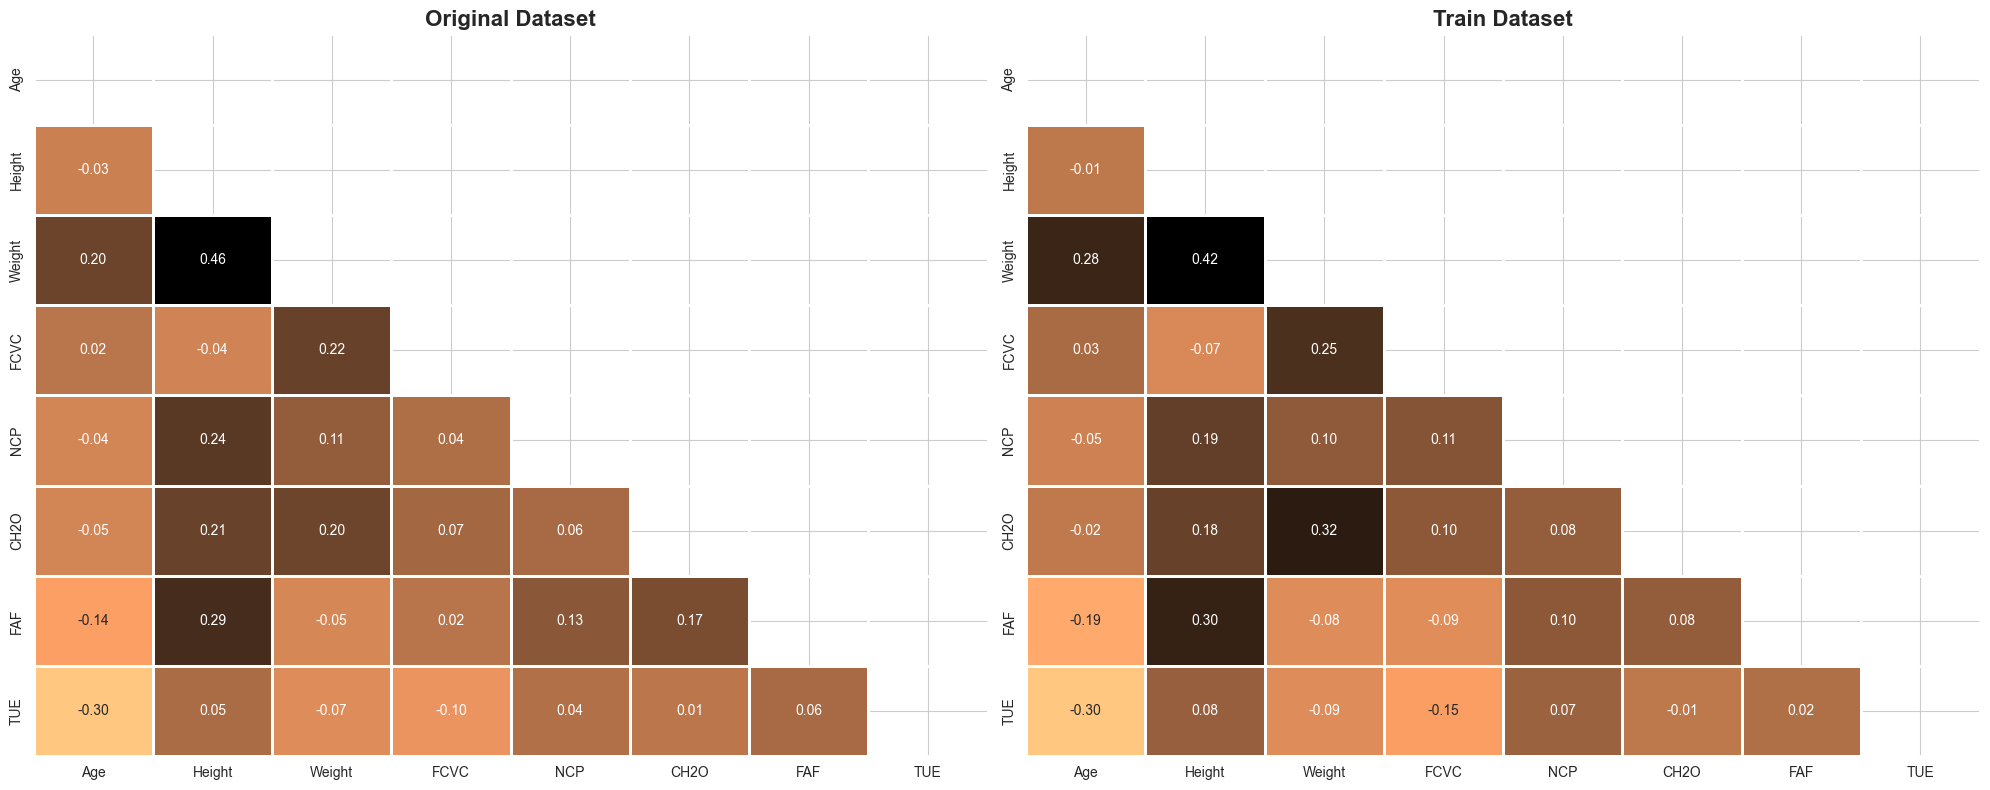

In [20]:
#Correlation heatmap
numeric_columns_original = original.select_dtypes(include=np.number)
numeric_columns_train = df_train.select_dtypes(include=np.number).drop(['id','BMI'], axis=1)
# original
corr_original = numeric_columns_original.corr(method='pearson')
mask_original = np.triu(np.ones_like(corr_original))
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
sns.heatmap(corr_original, annot=True, fmt='.2f', mask=mask_original, cmap='copper_r', cbar=None, linewidth=2, ax=axes[0])
axes[0].set_title('Original Dataset', fontsize=16, fontweight='bold')

# Train
corr_train = numeric_columns_train.corr(method='pearson')
mask_train = np.triu(np.ones_like(corr_train))
sns.heatmap(corr_train, annot=True, fmt='.2f', mask=mask_train, cmap='copper_r', cbar=None, linewidth=2, ax=axes[1])
axes[1].set_title('Train Dataset', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

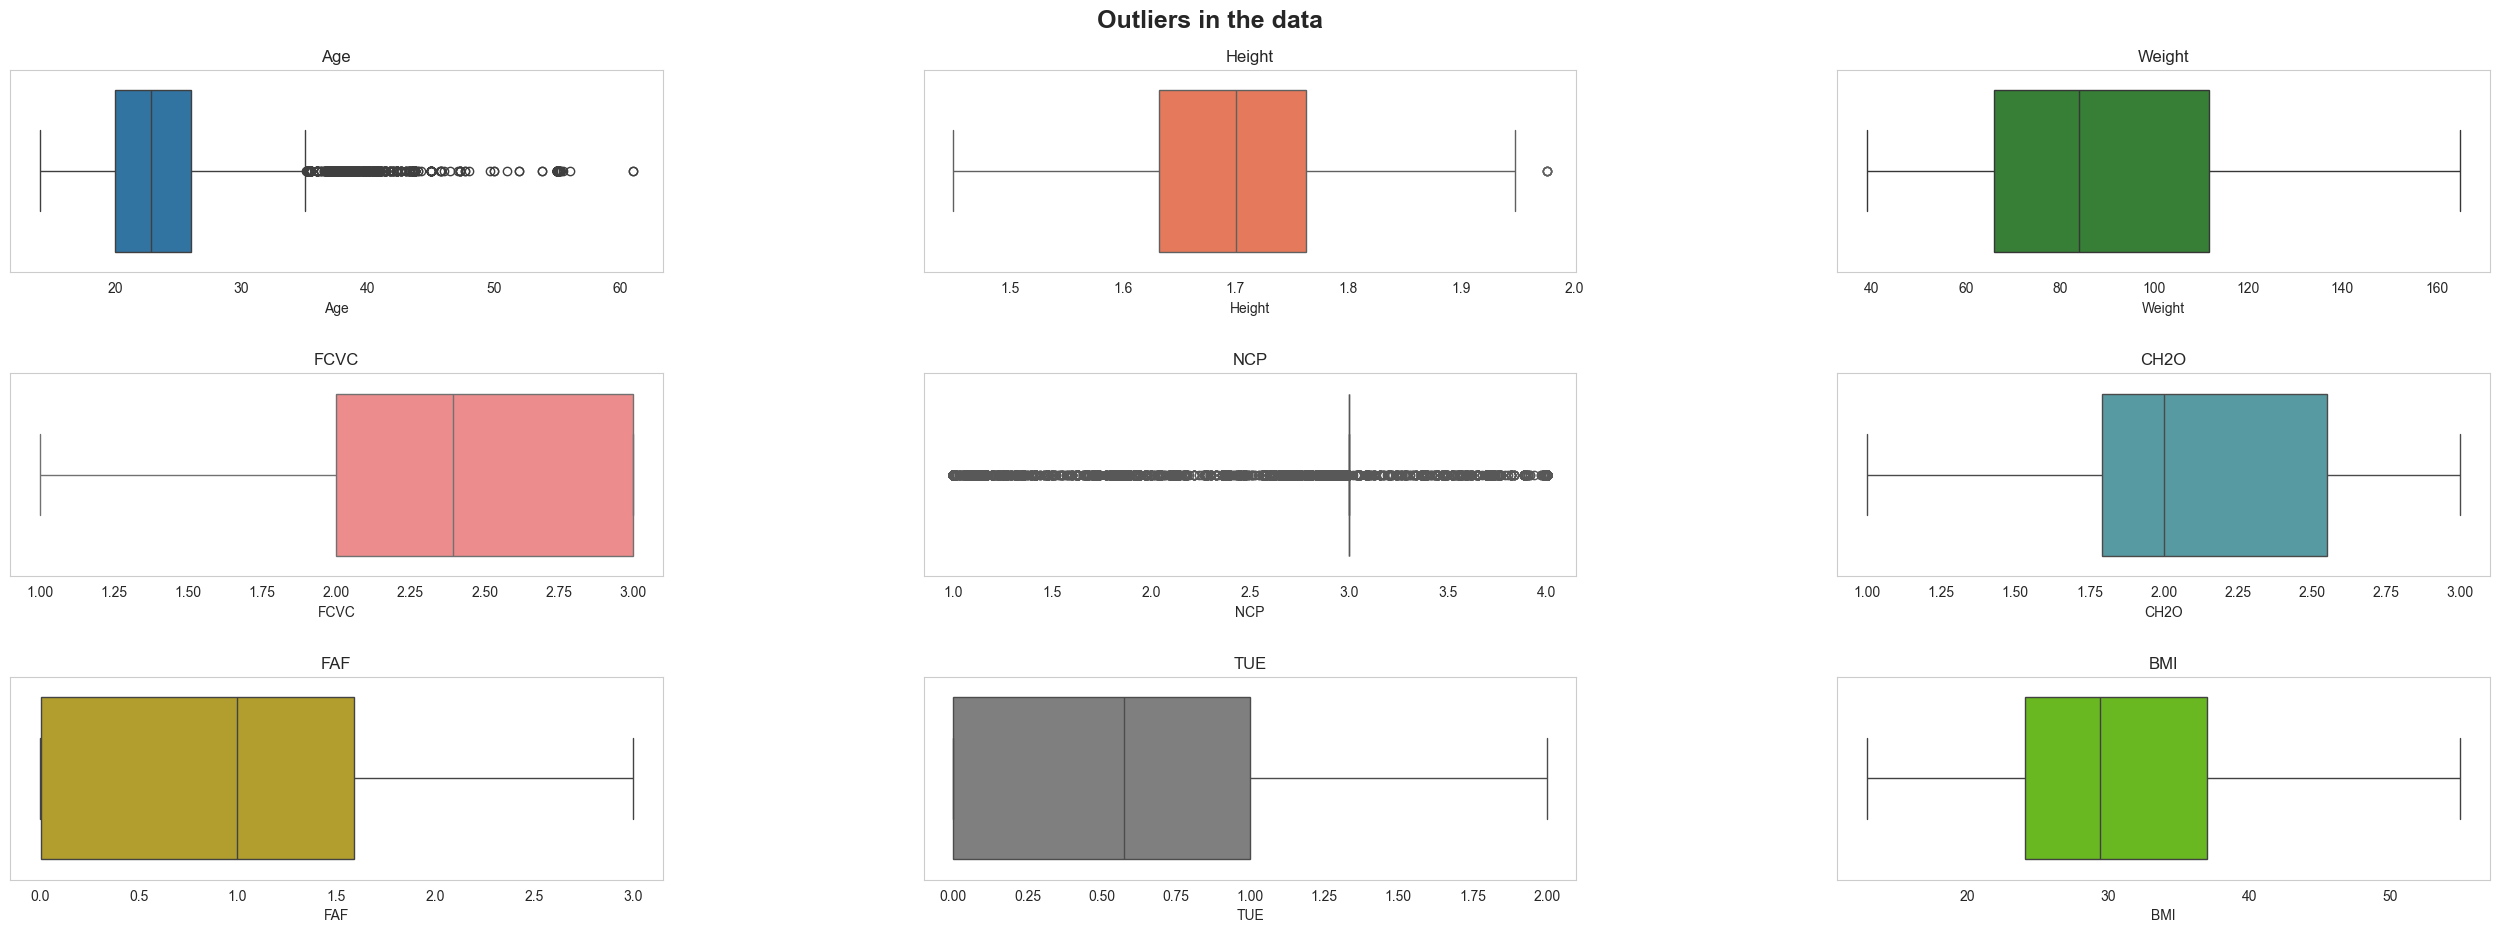

In [21]:
#Check for presence of outliers in each feature
numeric_columns = df_train.select_dtypes(include=['float64', 'int64']).drop(columns=['id'], axis=1)
fig = plt.figure(figsize=[32,10])
plt.suptitle('Outliers in the data', fontsize=18, fontweight='bold')
fig.subplots_adjust(top=0.92);
fig.subplots_adjust(hspace=0.5, wspace=0.4);
for i ,col in enumerate(numeric_columns):
    ax = fig.add_subplot(3,3, i+1);
    ax = sns.boxplot(data = df_train, x=col ,  color= colors[i]);
    ax.set_title(f'{col}')
    ax.set_xlabel(f'{col}')
    ax.grid(False)
plt.show()

In [22]:
df_train = pd.read_csv('train.csv')
original = pd.read_csv('ObesityDataSet.csv')
df_test = pd.read_csv('test.csv')

In [23]:
def get_variable_types(dataframe):
    continuous_vars = []
    categorical_vars = []

    for column in dataframe.columns:
        if dataframe[column].dtype == 'object':
            categorical_vars.append(column)
        else:
            continuous_vars.append(column)

    return continuous_vars, categorical_vars

continuous_vars, categorical_vars = get_variable_types(df_train)
categorical_vars.remove('NObeyesdad')

In [24]:
train = pd.concat([df_train, original]).drop(['id'], axis=1).drop_duplicates()
test = df_test.drop(['id'], axis=1)

In [25]:
train = pd.get_dummies(train, columns=categorical_vars, drop_first=True)
test = pd.get_dummies(test, columns=categorical_vars, drop_first=True)

In [26]:
train.head()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,NObeyesdad,Gender_Male,...,CAEC_no,SMOKE_yes,SCC_yes,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,24.443011,1.699998,81.669950,2.000000,2.983297,2.763573,0.000000,0.976473,Overweight_Level_II,True,...,False,False,False,False,True,False,False,False,True,False
1,18.000000,1.560000,57.000000,2.000000,3.000000,2.000000,1.000000,1.000000,Normal_Weight,False,...,False,False,False,False,False,True,False,False,False,False
2,18.000000,1.711460,50.165754,1.880534,1.411685,1.910378,0.866045,1.673584,Insufficient_Weight,False,...,False,False,False,False,False,True,False,False,True,False
3,20.952737,1.710730,131.274851,3.000000,3.000000,1.674061,1.467863,0.780199,Obesity_Type_III,False,...,False,False,False,False,True,False,False,False,True,False
4,31.641081,1.914186,93.798055,2.679664,1.971472,1.979848,1.967973,0.931721,Overweight_Level_II,True,...,False,False,False,False,True,False,False,False,True,False


In [27]:
print(f'Encoded Train: {train.shape[0]} rows and {train.shape[1]} columns')
print(f'Encoded Test: {test.shape[0]} rows and {test.shape[1]} columns')


Encoded Train: 22845 rows and 24 columns
Encoded Test: 13840 rows and 23 columns


In [28]:
X = train.drop(['NObeyesdad'], axis=1)
y = train['NObeyesdad']

In [29]:
X.shape

(22845, 23)

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [33]:
# # Define the objective function for Optuna optimization
# import optuna
# from optuna.samplers import TPESampler
# 
# def objective(trial, X_train, y_train, X_test, y_test):
#      # Define parameters to be optimized for the LGBMClassifier
#      param = {
#          "objective": "multiclass",
#          "metric": "multi_logloss",
#          "verbosity": -1,
#          "boosting_type": "gbdt",
#          "random_state": 42,
#          "num_class": 7,
#          "learning_rate": trial.suggest_f   loat("learning_rate", 0.001, 0.2),
#          "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
#          "lambda_l1": trial.suggest_float("lambda_l1", 0.005, 0.015),
#          "lambda_l2": trial.suggest_float("lambda_l2", 0.02, 0.06),
#          "max_depth": trial.suggest_int("max_depth", 5, 20),
#          "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 0.9),
#          "subsample": trial.suggest_float("subsample", 0.8, 1.0),
#          "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
#      }
# 
#  # LGBMClassifier with the suggested parameters
#      lgbm_classifier = LGBMClassifier(**param)
#     
# # Fit 
#      lgbm_classifier.fit(X_train, y_train)
# 
# # Evaluate
#      score = lgbm_classifier.score(X_test, y_test, )
# 
#      return score
# 
# # Train Test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 
# 
# #sampler for Optuna optimization
# sampler = optuna.samplers.TPESampler(seed=42)  # Using Tree-structured Parzen Estimator sampler for optimization
# 
# # Create a study object
# study = optuna.create_study(direction="maximize", sampler=sampler)
# 
# # Run the optimization process
# study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test), n_trials=50)
# 
# # best parameters after optimization
# best_params = study.best_params
# 
# print('='*50)
# print(best_params)

In [34]:
# Best parameters: https://www.kaggle.com/code/moazeldsokyx/pgs4e2-highest-score-lgbm-hyperparameter-tuning/notebook

best_hyper_params = {
    "objective": "multiclass",          # Objective function for the model
    "metric": "multi_logloss",          # Evaluation metric
    "verbosity": -1,                    # Verbosity level (-1 for silent)
    "boosting_type": "gbdt",            # Gradient boosting type
    "random_state": 42,       # Random state for reproducibility
    "num_class": 7,                     # Number of classes in the dataset
'learning_rate': 0.011978527382971352, 'n_estimators': 509, 'lambda_l1': 0.009715116714365276, 'lambda_l2': 0.03853395161282091, 'max_depth': 11, 'colsample_bytree': 0.7364306508830605, 'subsample': 0.9529973839959326, 'min_child_samples': 17
}

In [35]:
lgbm_classifier = LGBMClassifier(**best_hyper_params)
lgbm_classifier.fit(X_train, y_train)
y_pred = lgbm_classifier.predict(X_test)

In [36]:
accuracy_score(y_test, y_pred)

0.9159553512803676

In [37]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, y_pred))

                     precision    recall  f1-score   support

Insufficient_Weight       0.93      0.95      0.94       574
      Normal_Weight       0.90      0.90      0.90       677
     Obesity_Type_I       0.93      0.88      0.90       682
    Obesity_Type_II       0.96      0.97      0.97       697
   Obesity_Type_III       1.00      1.00      1.00       878
 Overweight_Level_I       0.80      0.82      0.81       525
Overweight_Level_II       0.83      0.84      0.83       536

           accuracy                           0.92      4569
          macro avg       0.91      0.91      0.91      4569
       weighted avg       0.92      0.92      0.92      4569



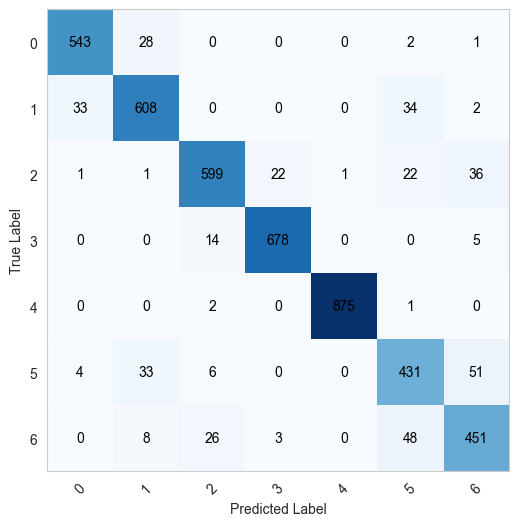

In [38]:
# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
from lightgbm import LGBMClassifier, plot_importance
plt.figure(figsize=(15, 6))
conf_matrix = confusion_matrix(y_test, y_pred)
conf_labels = [f'{i}' for i in range(conf_matrix.shape[0])]
conf_matrix_df = pd.DataFrame(conf_matrix, columns=conf_labels, index=conf_labels)
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.xticks(np.arange(conf_matrix.shape[0]), conf_labels, rotation=45)
plt.yticks(np.arange(conf_matrix.shape[0]), conf_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='black')
plt.grid(False)
plt.show()

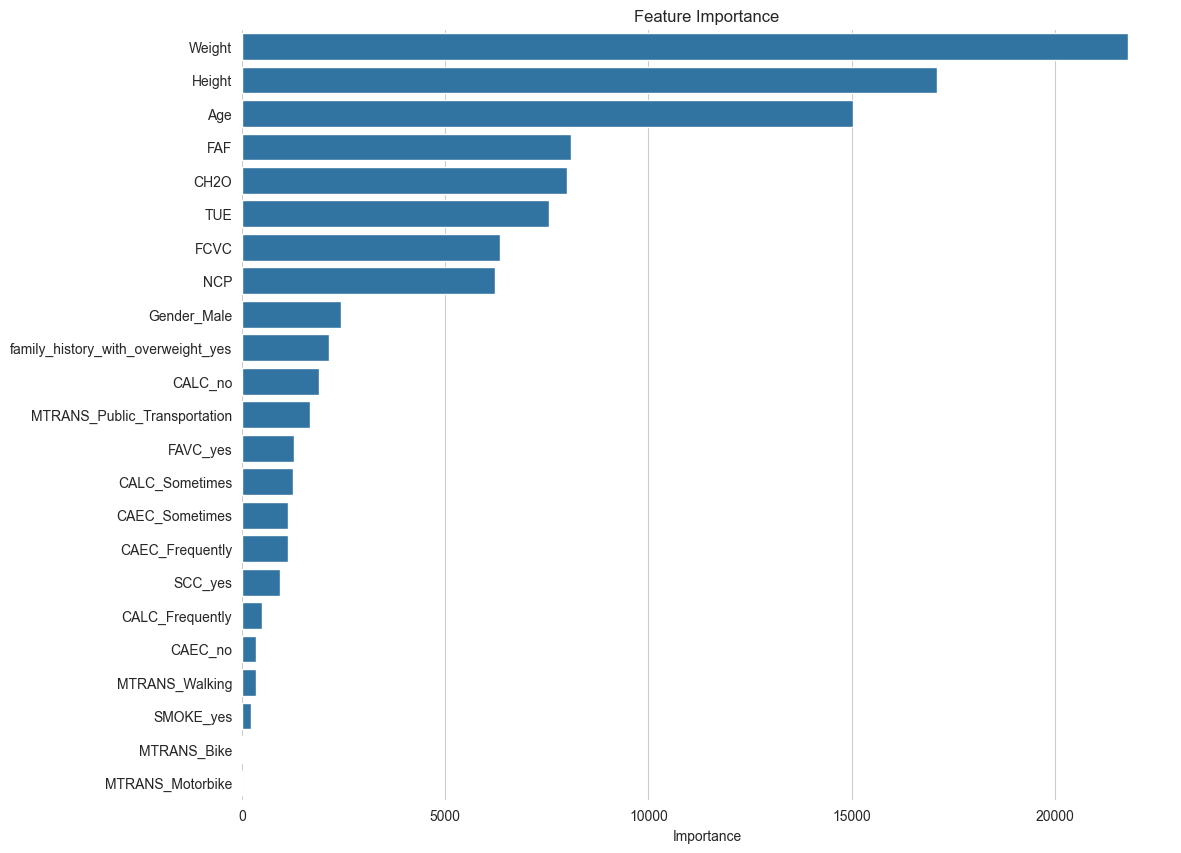

In [39]:
# feature importances
feature_importance = lgbm_classifier.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('')
sns.despine(left=True, bottom=True)
plt.show()

In [40]:
X.head()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Male,family_history_with_overweight_yes,...,CAEC_no,SMOKE_yes,SCC_yes,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,24.443011,1.699998,81.669950,2.000000,2.983297,2.763573,0.000000,0.976473,True,True,...,False,False,False,False,True,False,False,False,True,False
1,18.000000,1.560000,57.000000,2.000000,3.000000,2.000000,1.000000,1.000000,False,True,...,False,False,False,False,False,True,False,False,False,False
2,18.000000,1.711460,50.165754,1.880534,1.411685,1.910378,0.866045,1.673584,False,True,...,False,False,False,False,False,True,False,False,True,False
3,20.952737,1.710730,131.274851,3.000000,3.000000,1.674061,1.467863,0.780199,False,True,...,False,False,False,False,True,False,False,False,True,False
4,31.641081,1.914186,93.798055,2.679664,1.971472,1.979848,1.967973,0.931721,True,True,...,False,False,False,False,True,False,False,False,True,False


In [41]:
test.head()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Male,family_history_with_overweight_yes,...,CAEC_no,SMOKE_yes,SCC_yes,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,26.899886,1.848294,120.644178,2.938616,3.000000,2.825629,0.855400,0.000000,True,True,...,False,False,False,False,True,False,False,False,True,False
1,21.000000,1.600000,66.000000,2.000000,1.000000,3.000000,1.000000,0.000000,False,True,...,False,False,False,False,True,False,False,False,True,False
2,26.000000,1.643355,111.600553,3.000000,3.000000,2.621877,0.000000,0.250502,False,True,...,False,False,False,False,True,False,False,False,True,False
3,20.979254,1.553127,103.669116,2.000000,2.977909,2.786417,0.094851,0.000000,True,True,...,False,False,False,False,True,False,False,False,True,False
4,26.000000,1.627396,104.835346,3.000000,3.000000,2.653531,0.000000,0.741069,False,True,...,False,False,False,False,True,False,False,False,True,False


In [42]:
predictions = lgbm_classifier.predict(test)
predictions

array(['Obesity_Type_II', 'Overweight_Level_I', 'Obesity_Type_III', ...,
       'Insufficient_Weight', 'Normal_Weight', 'Obesity_Type_II'],
      dtype=object)

In [64]:
import pickle
# Save the model
pickle.dump(lgbm_classifier, open('lgbm_classifier.pkl','wb'))

In [65]:
test.columns

Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE',
       'Gender_Male', 'family_history_with_overweight_yes', 'FAVC_yes',
       'CAEC_Frequently', 'CAEC_Sometimes', 'CAEC_no', 'SMOKE_yes', 'SCC_yes',
       'CALC_Frequently', 'CALC_Sometimes', 'CALC_no', 'MTRANS_Bike',
       'MTRANS_Motorbike', 'MTRANS_Public_Transportation', 'MTRANS_Walking'],
      dtype='object')

In [66]:
import pandas as pd

# Create a dictionary with sample data
sample_data = {
    'Age': 20,
    'Height': 1.76,
    'Weight': 72,
    'FCVC': 3,
    'NCP': 2,
    'CH2O': 2,
    'FAF': 1,
    'TUE': 2,
    'Gender_Male': 1,  # One-hot encoded feature, assuming Male
    'family_history_with_overweight_yes': 1,  # One-hot encoded feature, assuming Yes
    'FAVC_yes': 1,  # One-hot encoded feature, assuming Yes
    'CAEC_Frequently': 0,  # One-hot encoded feature, assuming Not Frequently
    'CAEC_Sometimes': 1,  # One-hot encoded feature, assuming Sometimes
    'CAEC_no': 0,  # One-hot encoded feature, assuming No
    'SMOKE_yes': 0,  # One-hot encoded feature, assuming No
    'SCC_yes': 0,  # One-hot encoded feature, assuming No
    'CALC_Frequently': 0,  # One-hot encoded feature, assuming Not Frequently
    'CALC_Sometimes': 1,  # One-hot encoded feature, assuming Sometimes
    'CALC_no': 0,  # One-hot encoded feature, assuming No
    'MTRANS_Bike': 0,  # One-hot encoded feature, assuming not Bike
    'MTRANS_Motorbike': 0,  # One-hot encoded feature, assuming not Motorbike
    'MTRANS_Public_Transportation': 1,  # One-hot encoded feature, assuming Public Transportation
    'MTRANS_Walking': 0  # One-hot encoded feature, assuming not Walking
}

# Convert the dictionary to a DataFrame
sample_df = pd.DataFrame(sample_data, index=[0])

import pickle

# Load the trained model from the pickle file
with open('lgbm_classifier.pkl', 'rb') as f:
    model = pickle.load(f)

# Use the loaded model to make predictions
predictions = model.predict(sample_df)
predictions

array(['Normal_Weight'], dtype=object)

In [68]:
from huggingface_hub import hf_hub_download
import joblib

REPO_ID = "sardal/obesity_risk"
FILENAME = "lgbm_classifier.pkl"

model = joblib.load(
    hf_hub_download(repo_id=REPO_ID, filename=FILENAME)
)

lgbm_classifier.pkl:   0%|          | 0.00/12.1M [00:00<?, ?B/s]

In [69]:
model.predict(sample_df)

array(['Normal_Weight'], dtype=object)